In [9]:
# !python -m spacy download en_core_web_md -q

✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_md')


In [60]:
import json
import openai
from collections import Counter
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
import nltk
import spacy
import pytextrank
import gspread
import pandas as pd
import en_core_web_md
from gensim.corpora.dictionary import Dictionary
from gensim.models import LdaMulticore
from gensim.models import CoherenceModel
import re
import matplotlib.pyplot as plt
from wordcloud import WordCloud
import operator

import pyLDAvis.gensim_models

# Visualise inside a notebook
pyLDAvis.enable_notebook()


nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')

stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()
import numpy as np


[nltk_data] Downloading package punkt to /home/niko/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /home/niko/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /home/niko/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [19]:
# Read and parse the JSON settings file
with open('../settings.json') as settings_file:
    settings = json.load(settings_file)

In [20]:
# Set your OpenAI API key
openai.api_key = settings['OPENAI_API_KEY']


In [22]:

# read data from csv
df_data = pd.read_csv('../data/exports/article_abstracts.csv')

In [24]:

nlp = en_core_web_md.load()

# Tags I want to remove from the text
removal = ['ADV', 'PRON', 'CCONJ', 'PUNCT',
           'PART', 'DET', 'ADP', 'SPACE', 'NUM', 'SYM']

tokens = []
for abstract in nlp.pipe(df_data['abstract_modified']):
   proj_tok = [token.lemma_.lower(
   ) for token in abstract if token.pos_ not in removal and not token.is_stop and token.is_alpha and len(token) > 2]
   tokens.append(proj_tok)
   
# https://towardsdatascience.com/topic-modelling-in-python-with-spacy-and-gensim-dc8f7748bdbf
# https://stackoverflow.com/questions/73378057/how-to-debug-remote-python-script-in-vs-code

df_data['Tokenized'] = tokens_concatenated

dictionary = Dictionary(tokens)
# print(dictionary.token2id)

dictionary.filter_extremes(no_below=5, no_above=0.5, keep_n=1000)

corpus = [dictionary.doc2bow(doc) for doc in tokens]


In [25]:
tokens_count = dict(Counter(sum(tokens, [])))
tokens_count = dict(
    sorted(tokens_count.items(), key=operator.itemgetter(1), reverse=True))


In [26]:
tokens_count_df = pd.DataFrame(tokens_count.items(), columns=['token', 'occurences_count']).sort_values('occurences_count', ascending=False)

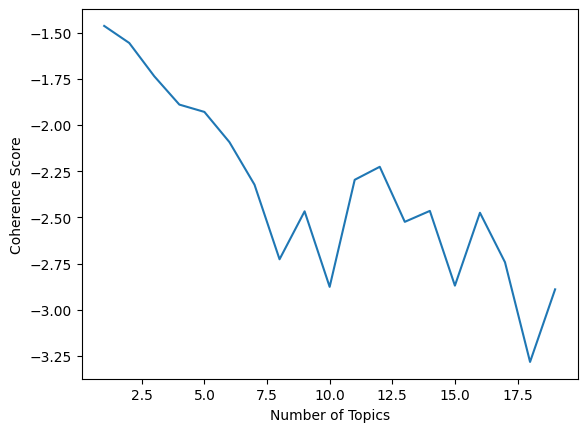

In [28]:

lda_model = LdaMulticore(corpus=corpus, id2word=dictionary, iterations=50, num_topics=10, workers = 4, passes=10)

topics = []
score = []
for i in range(1,20,1):
   lda_model = LdaMulticore(corpus=corpus, id2word=dictionary, iterations=10, num_topics=i, workers = 4, passes=10, random_state=100)
   cm = CoherenceModel(model=lda_model, corpus=corpus, dictionary=dictionary, coherence='u_mass')
   topics.append(i)
   score.append(cm.get_coherence())
_=plt.plot(topics, score)
_=plt.xlabel('Number of Topics')
_=plt.ylabel('Coherence Score')
plt.show()


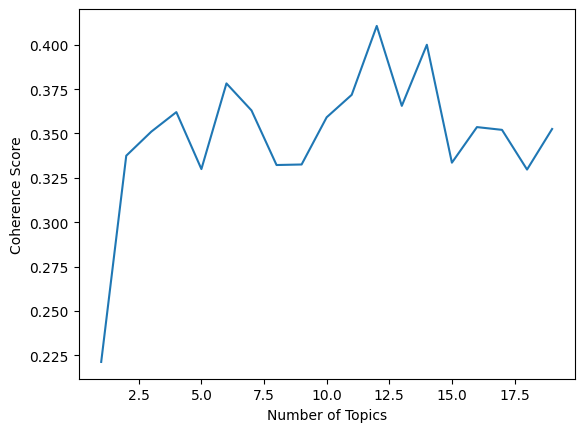

In [29]:

# Coherence score using C_v:
topics = []
score = []
for i in range(1,20,1):
   lda_model = LdaMulticore(corpus=corpus, id2word=dictionary, iterations=10, num_topics=i, workers = 4, passes=10, random_state=100)
   cm = CoherenceModel(model=lda_model, texts = tokens, corpus=corpus, dictionary=dictionary, coherence='c_v')
   topics.append(i)
   score.append(cm.get_coherence())
_=plt.plot(topics, score)
_=plt.xlabel('Number of Topics')
_=plt.ylabel('Coherence Score')
plt.show()


In [37]:

# Optimal model
num_topics = 11
lda_model = LdaMulticore(corpus=corpus, id2word=dictionary, iterations=100, num_topics=num_topidef get_most_probable_topic(df):
    topic_cols = [col for col in df.columns if col.startswith('topic_')]
    topic_probs = df[topic_cols].values
    most_probable_topic = np.argmax(topic_probs, axis=1)
    result = df.copy()
    result['most_probable_topic'] = most_probable_topic
    return result

In [38]:
topic_words = [
    re.findall(r'"(.*?)"', tup[1]) for tup in lda_model.print_topics(-1)
]


In [39]:
nested_list = list(map(lambda x: [x[0], list(map(lambda y: y.replace(
    '"', '').split('*'), x[1].split(' + ')))], lda_model.print_topics(-1)))
flattened_list = [(index, float(prob), word)
                  for index, inner_list in nested_list for prob, word in inner_list]


In [40]:
flattened_list

[(0, 0.064, 'organic'),
 (0, 0.037, 'carbon'),
 (0, 0.035, 'activity'),
 (0, 0.031, 'matter'),
 (0, 0.028, 'total'),
 (0, 0.028, 'rate'),
 (0, 0.023, 'correlate'),
 (0, 0.02, 'microbial'),
 (0, 0.02, 'biomass'),
 (0, 0.019, 'increase'),
 (1, 0.06, 'manure'),
 (1, 0.03, 'green'),
 (1, 0.027, 'legume'),
 (1, 0.025, 'field'),
 (1, 0.023, 'study'),
 (1, 0.023, 'incubation'),
 (1, 0.021, 'method'),
 (1, 0.017, 'crop'),
 (1, 0.016, 'organic'),
 (1, 0.016, 'research'),
 (2, 0.055, 'plant'),
 (2, 0.053, 'organic'),
 (2, 0.025, 'amendment'),
 (2, 0.025, 'net'),
 (2, 0.023, 'fertilizer'),
 (2, 0.02, 'som'),
 (2, 0.018, 'availability'),
 (2, 0.018, 'measure'),
 (2, 0.017, 'ecosystem'),
 (2, 0.017, 'input'),
 (3, 0.067, 'crop'),
 (3, 0.026, 'system'),
 (3, 0.024, 'model'),
 (3, 0.02, 'corn'),
 (3, 0.018, 'study'),
 (3, 0.015, 'residue'),
 (3, 0.014, 'fertilizer'),
 (3, 0.014, 'production'),
 (3, 0.014, 'cropping'),
 (3, 0.014, 'incubation'),
 (4, 0.035, 'incubation'),
 (4, 0.031, 'mineralize'),
 (

In [41]:
str_topic_words = '[' + '], ['.join([', '.join(tup) for tup in topic_words]) + ']'

In [42]:
str_topic_words


'[organic, carbon, activity, matter, total, rate, correlate, microbial, biomass, increase], [manure, green, legume, field, study, incubation, method, crop, organic, research], [plant, organic, amendment, net, fertilizer, som, availability, measure, ecosystem, input], [crop, system, model, corn, study, residue, fertilizer, production, cropping, incubation], [incubation, mineralize, organic, estimate, model, rate, net, range, mineralizable, index], [wheat, mineral, legume, effect, assess, vicia, yield, microbial, community, potential], [wheat, winter, increase, pea, uptake, tillage, spring, crop, plant, yield], [residue, crop, pea, field, legume, root, grow, study, effect, dynamic], [effect, manure, treatment, rate, application, year, fertilizer, increase, source, residue], [rate, gross, crop, determine, specie, dilution, poultry, growth, fertilizer, tool], [nmin, laboratory, potential, net, supply, field, study, predict, microbial, global]'

In [43]:
messages = [ {"role": "system", "content": f"in the list below there are multiple clusters defined by the list of words. for every list of words find an appropriate topic to describe the set of words: {str_topic_words}"} ]

In [46]:
chat = openai.ChatCompletion.create(
    model="gpt-4", messages=messages
)

In [47]:
reply = chat.choices[0].message.content


In [48]:
topic_names = [re.sub(r'^\d+\.\s*', '', item) for item in reply.split('\n')]



In [49]:
for words, topic in zip(topic_words, topic_names):
    print(f"{topic}: {', '.join(words)}")

Microbial activity and organic carbon in soil: organic, carbon, activity, matter, total, rate, correlate, microbial, biomass, increase
Organic manure and crop research: manure, green, legume, field, study, incubation, method, crop, organic, research
Organic fertilizers and plant ecosystem: plant, organic, amendment, net, fertilizer, som, availability, measure, ecosystem, input
Crop modeling and fertilizer management: crop, system, model, corn, study, residue, fertilizer, production, cropping, incubation
Organic matter mineralization and estimation models: incubation, mineralize, organic, estimate, model, rate, net, range, mineralizable, index
Legume effects on wheat yield and microbial communities: wheat, mineral, legume, effect, assess, vicia, yield, microbial, community, potential
Winter wheat and spring pea intercropping: wheat, winter, increase, pea, uptake, tillage, spring, crop, plant, yield
Legume root dynamics in crop residue management: residue, crop, pea, field, legume, root,

In [50]:
topic_names

['Microbial activity and organic carbon in soil',
 'Organic manure and crop research',
 'Organic fertilizers and plant ecosystem',
 'Crop modeling and fertilizer management',
 'Organic matter mineralization and estimation models',
 'Legume effects on wheat yield and microbial communities',
 'Winter wheat and spring pea intercropping',
 'Legume root dynamics in crop residue management',
 'Manure application effects on soil fertility',
 'Gross fertilizer rates and species-specific growth',
 'Net mineralizable nitrogen in laboratory and field studies']

In [52]:
# Enumerate the topics_list to have the index with each item
indexed_topics = [(i, topic) for i, topic in enumerate(topic_names)]

In [53]:
# Merge the two lists
merged_list = [
    {"number": number, "probability": prob, "word": word, "topic": topic}
    for number, prob, word in flattened_list
    for idx, topic in indexed_topics
    if number == idx
]


In [54]:
df_word_prob = pd.DataFrame(merged_list)


In [101]:
df_word_prob.head()

,number,probability,word,topic
0,0,0.183,rice,Crops and Cropping Systems
1,0,0.104,corn,Crops and Cropping Systems
2,0,0.049,grain,Crops and Cropping Systems
3,0,0.041,legume,Crops and Cropping Systems
4,0,0.039,fertilizer,Crops and Cropping Systems


In [56]:
bow = dictionary.doc2bow(df_data['abstract_modified'].iloc[0].lower().split())
gamma_probs = lda_model.get_document_topics(bow, minimum_probability=0)


In [57]:
gamma_probs


[(0, 0.0025254944),
 (1, 0.11194898),
 (2, 0.0025255599),
 (3, 0.00252542),
 (4, 0.0025255063),
 (5, 0.0025254122),
 (6, 0.86532176),
 (7, 0.0025255645),
 (8, 0.0025254078),
 (9, 0.0025254942),
 (10, 0.0025254795)]

In [58]:
topic_probs = []
for _, row in df_data.iterrows():
    abstract = row['abstract_modified'].lower()
    bow = dictionary.doc2bow(abstract.split())
    gamma_probs = lda_model.get_document_topics(bow, minimum_probability=0)
    topic_probs.append([abstract] + [prob for _, prob in gamma_probs])
df_topic_probs = pd.DataFrame(topic_probs, columns=['abstract'] + [f'topic_{i}' for i in range(num_topics)])

In [68]:
def get_most_probable_topic(df):
    topic_cols = [col for col in df.columns if col.startswith('topic_')]
    topic_probs = df[topic_cols].values
    most_probable_topic_indices = np.argmax(topic_probs, axis=1)
    result = df.copy()
    result['most_probable_topic'] = list(map(lambda x: topic_names[x], most_probable_topic_indices))
    return result

In [69]:
df_topic_probs = get_most_probable_topic(df_topic_probs)

In [70]:
df_topic_probs.head()

,abstract,topic_0,topic_1,topic_2,topic_3,topic_4,topic_5,topic_6,topic_7,topic_8,topic_9,topic_10,most_probable_topic
0,organic farmers in semiarid montana desire gre...,0.002525,0.111963,0.002526,0.002525,0.002526,0.002525,0.865307,0.002526,0.002525,0.002525,0.002525,Winter wheat and spring pea intercropping
1,climate change will lead to changes in soil mo...,0.905864,0.003497,0.003497,0.003497,0.003497,0.003497,0.062664,0.003497,0.003497,0.003497,0.003497,Microbial activity and organic carbon in soil
2,the objectives of this greenhouse experiment w...,0.003953,0.094447,0.003953,0.003953,0.003953,0.345830,0.003953,0.284826,0.247227,0.003953,0.003953,Legume effects on wheat yield and microbial co...
3,a number of approaches have been used to model...,0.006994,0.006993,0.527202,0.145488,0.006994,0.006993,0.006994,0.006994,0.006993,0.006993,0.271360,Organic fertilizers and plant ecosystem
4,our objective was to examine the dynamics of o...,0.150527,0.002841,0.225880,0.069358,0.002842,0.002841,0.002842,0.534344,0.002841,0.002841,0.002842,Legume root dynamics in crop residue management


In [72]:
# save df_topic_probs to csv file
df_topic_probs.to_csv('../data/exports/articles_by_topics.csv', index=False)